# Business Analytics
## Recommendation Analytics & k-NN
(C) 2021

In [1]:
from IPython.display import HTML, display

def optional_material():
    '''
    When run in a cell, this function will color the cell blue to indicate
    the material is optional
    '''
    script =  "var cell = this.closest('.code_cell');"
    script += "var editor = cell.querySelector('.input_area');"
    script += "editor.style.background='#bde4f0';"
    script += "this.parentNode.removeChild(this)"
    
    display(HTML(f'<img src onerror="{script}">'))
    
optional_material()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:900px !important; }</style>"))

# Calculating CLV in B2B Businesses

### Load the data

In [2]:
import pandas as pd

In [3]:
# Load the B2B data
df_customers = pd.read_csv('/Users/gujiajun/Downloads/B2B sales.csv')
df_customers.head()

,Dept 1,Dept 2,Dept 3,Dept 4,Dept 5,ltv
0,52,17,45,22,53,5989
1,89,74,0,35,83,6960
2,94,71,39,87,83,7783
3,78,29,19,37,1,5405
4,5,81,35,77,25,6207


In [4]:
len(df_customers)

5000

### Split into a training and test set

In [5]:
import sklearn.model_selection as sk_ms

In [6]:
df_train, df_test = sk_ms.train_test_split(df_customers,
                                           train_size = 0.7,
                                           random_state = 123,
                                           shuffle = True)

In [7]:
print(len(df_train))
print(len(df_test))

3500
1500


### Linear regression

In [8]:
import sklearn.linear_model as sk_lm
import sklearn.metrics as sk_m

In [9]:
# Fit a linear regression model on the training set
lm = sk_lm.LinearRegression()
lm.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

LinearRegression()

In [10]:
# Make predictions on the test set
preds = lm.predict(df_test.loc[:, df_test.columns != 'ltv'])

In [11]:
# Find the R-squared on the test set
sk_m.r2_score(df_test.ltv, preds)

0.0910480787721818

### k-NN (no parameter)

In [12]:
import sklearn.neighbors as sk_n

In [13]:
# Fit a k-NN model on the training set
knn = sk_n.KNeighborsRegressor()
knn.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

KNeighborsRegressor()

In [14]:
# Make predictions on the test set
preds = knn.predict(df_test.loc[:, df_test.columns != 'ltv'])

In [15]:
# Find the R-squared on the test set
sk_m.r2_score(df_test.ltv, preds)

0.1856864161737649

### k-NN (specifying a parameter)

In [16]:
# Fit a k-NN model on the training set
knn = sk_n.KNeighborsRegressor(n_neighbors=12)
knn.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

# Make predictions on the test set
preds = knn.predict(df_test.loc[:, df_test.columns != 'ltv'])

# Find the R-squared on the test set
sk_m.r2_score(df_test.ltv, preds)

0.27404913183392743

### k-NN (picking the best parameter)

100%|██████████| 36/36 [00:01<00:00, 25.82it/s]


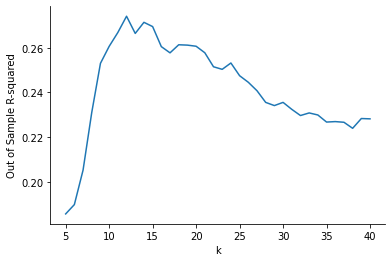

In [17]:
# Go through values of k between 5 and 40, train a k-NN model
# for each value, see how will it does on the test set, and
# store the results in a list
score_list = []

import tqdm
for k in tqdm.tqdm(range(5, 41)):
    knn = sk_n.KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

    # Make predictions on the test set
    preds = knn.predict(df_test.loc[:, df_test.columns != 'ltv'])

    # Find the R-squared on the test set and append it to the
    # score list
    score_list.append(sk_m.r2_score(df_test.ltv, preds))

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(range(5, 41), score_list)
plt.xlabel('k')
plt.ylabel('Out of Sample R-squared')
sns.despine()

# Memory-based collaborative filtering

### Load the Canvas survey results

In [21]:
optional_material()

import pandas as pd
import string
import numpy as np

# Load the canvas data
raw_data = pd.read_csv('canvas_survey.csv')

# Find the relevant columns in the Excel spreadsheet
#   - name: the column number containing the name
#   - section_col: the column number containing the section
#   - gender_col: the column number containing the gender
#   - movie_cols: a list of column numbers containing the
#                 movie scores
#   - cuisines_cols: a list of column numbers containing
#                    the cuisine scores
def find_col(filter_func, restrict_to_one = False):
    matching_cols = [i for i, j in enumerate(raw_data.columns) if filter_func(j)]
    if restrict_to_one:
        assert(len(matching_cols) == 1)
        return matching_cols[0]
    else:
        return matching_cols
    
name_col = find_col(lambda x : x == 'name', True)
section_col = find_col(lambda x : x == 'section', True)
gender_col = find_col(lambda x : 'gender' in x, True)
movie_cols = find_col(lambda x : 'movie' in x)
cuisine_cols = find_col(lambda x : 'cuisine' in x)

# Extract movie and cuisine names
def extract_name(s):
    s = s.split(":")[-1]
    s = [i for i in s if i in string.ascii_letters + " "]
    s = ''.join(s)
    return s.strip()

movies = [extract_name(raw_data.columns[i]) for i in movie_cols]
cuisines = [extract_name(raw_data.columns[i]) for i in cuisine_cols]

# Create the DataFrames
movies_df = {'name':raw_data.iloc[:, name_col],
             'section':raw_data.iloc[:, section_col].str.split('_').str[1],
             'gender':raw_data.iloc[:, gender_col]}
cuisines_df = {'name':raw_data.iloc[:, name_col],
               'section':raw_data.iloc[:, section_col].str.split('_').str[1],
               'gender':raw_data.iloc[:, gender_col]}

get_rating = lambda x : float('nan') if x.lower() in ["haven't seen it","no opinion","nan"] else int(x)

for name, col in zip(movies, movie_cols):
    movies_df[name] = raw_data.iloc[:, col].astype(str).apply(get_rating).tolist()

for name, col in zip(cuisines, cuisine_cols):
    cuisines_df[name] = raw_data.iloc[:, col].astype(str).apply(get_rating).tolist()

df_movies = pd.DataFrame(movies_df)
df_cuisines = pd.DataFrame(cuisines_df)

FileNotFoundError: [Errno 2] No such file or directory: 'canvas_survey.csv'

Filter by section if required

In [19]:
df_movies = df_movies[df_movies.section == '005']

NameError: name 'df_movies' is not defined

In [20]:
df_dg = pd.DataFrame({'name':'Daniel Guetta',
                      'section':np.nan,
                      'gender':'Male',
                      'The Godfather':np.nan,
                      'Vicky Cristina Barcelona':np.nan,
                      'Black Swan':np.nan,
                      'Top Gun':np.nan,
                      'Bourne Identity':3,
                      'Texas Chainsaw Massacre':np.nan,
                      'Pretty Woman':5,
                      'Bridesmaids':1,
                      'Life is Beautiful':5,
                      'Y Tu Mam Tambin':np.nan,
                      'Inception':5,
                      'Working Girl':np.nan,
                      'Pulp Fiction':np.nan,
                      'Moneyball':4,
                      'Titanic':5,
                      'Avatar':5,
                      'Dark Knight':4,
                      'Iron Man':np.nan,
                      'Crouching Tiger Hidden Dragon':np.nan,
                      'National Lampoons Animal House':np.nan}, index=[0])

df_movies = pd.concat([df_movies, df_dg]).reset_index(drop=True).copy()

In [21]:
print(movies)
df_movies.head()

['The Godfather', 'Vicky Cristina Barcelona', 'Black Swan', 'Top Gun', 'Bourne Identity', 'Texas Chainsaw Massacre', 'Pretty Woman', 'Bridesmaids', 'Life is Beautiful', 'Y Tu Mam Tambin', 'Inception', 'Working Girl', 'Pulp Fiction', 'Moneyball', 'Titanic', 'Avatar', 'Dark Knight', 'Iron Man', 'Crouching Tiger Hidden Dragon', 'National Lampoons Animal House']


,name,section,gender,The Godfather,Vicky Cristina Barcelona,Black Swan,Top Gun,Bourne Identity,Texas Chainsaw Massacre,Pretty Woman,...,Inception,Working Girl,Pulp Fiction,Moneyball,Titanic,Avatar,Dark Knight,Iron Man,Crouching Tiger Hidden Dragon,National Lampoons Animal House
0,Jiaping Zhang,005,Male,5.0,NaN,NaN,4.0,3.0,3.0,NaN,...,5.0,NaN,NaN,NaN,4.0,4.0,4.0,5.0,3.0,NaN
1,Tony Zheng,005,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,3.0,4.0,5.0,NaN,NaN,NaN
2,Jonathan Zhang,005,Male,5.0,NaN,NaN,2.0,NaN,3.0,NaN,...,4.0,NaN,5.0,NaN,3.0,4.0,2.0,3.0,5.0,NaN
3,Yifei Li,005,Female,3.0,2.0,4.0,3.0,2.0,2.0,5.0,...,2.0,3.0,2.0,5.0,3.0,2.0,3.0,5.0,4.0,4.0
4,Zhonglin Liu,005,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,4.0,5.0,NaN,5.0,4.0,NaN,NaN


### Get some summary statistics

In [22]:
# Find the movies that were seen by the most people
df_movies.set_index('name')[movies].notnull().sum(axis=0).sort_values()

Y Tu Mam Tambin                     5
National Lampoons Animal House     12
Vicky Cristina Barcelona           14
Working Girl                       18
Bridesmaids                        22
Moneyball                          29
Texas Chainsaw Massacre            30
Pretty Woman                       37
Pulp Fiction                       37
Bourne Identity                    38
Crouching Tiger Hidden Dragon      52
Top Gun                            54
Black Swan                         62
The Godfather                      64
Life is Beautiful                  66
Dark Knight                        79
Inception                          85
Iron Man                          105
Avatar                            108
Titanic                           113
dtype: int64

In [23]:
# Find the movies with the highest rankings
df_movies.set_index('name')[movies].mean(axis=0).sort_values()

Texas Chainsaw Massacre           2.800000
Working Girl                      3.222222
Y Tu Mam Tambin                   3.400000
Bridesmaids                       3.500000
National Lampoons Animal House    3.500000
Vicky Cristina Barcelona          3.500000
Black Swan                        3.693548
Pretty Woman                      3.702703
Iron Man                          3.771429
Top Gun                           3.833333
Bourne Identity                   3.868421
Pulp Fiction                      4.000000
The Godfather                     4.062500
Moneyball                         4.068966
Dark Knight                       4.088608
Crouching Tiger Hidden Dragon     4.096154
Avatar                            4.111111
Titanic                           4.221239
Life is Beautiful                 4.363636
Inception                         4.388235
dtype: float64

In [24]:
# Find the people that have seen the most and fewest movies
df_movies.set_index('name')[movies].notnull().sum(axis=1).sort_values()

name
Yueru Jin         1
Xinfang Zhang     1
Jiewan Yang       2
Xiao Zhang        2
Ziqi Dong         2
                 ..
Grace Liu        19
Meng He          19
Kaichen Ma       20
Shuyang Chen     20
Yifei Li         20
Length: 121, dtype: int64

In [25]:
# Find the most and least generous rankers
df_movies.set_index('name')[movies].mean(axis=1).sort_values()

name
Meng He          2.789474
Sophie Asgari    2.800000
Yi Gong          2.857143
Xiao Zhang       3.000000
Xiangyi Li       3.000000
                   ...   
Xinfang Zhang    5.000000
Yue Fei          5.000000
Jiaming Yuan     5.000000
liyue Chen       5.000000
Yueru Jin        5.000000
Length: 121, dtype: float64

### Prepare collaborative filtering functions

In [26]:
import math

In [27]:
def dist(x, y):
    '''
    This function takes two vectors, and finds the euclidean distance
    between them, using *only* the movies that are present in *both*
    vectors
    '''
    
    # Find the distance squared between the two vectors for each movie
    dists = [(i-j)**2 for i, j in zip(x,y)]
    
    # Find the number of movies that are present in both vectors
    n_movies = sum([pd.notnull(i) for i in dists])
    
    # Find the sum of distances squares for movies that are in both
    # vectors
    sum_dists = sum([i for i in dists if pd.notnull(i)])
    
    # If there are no overlapping ratings, return infinity. If not,
    # return the square root of the standardized distance
    if n_movies == 0:
        return float('inf')
    else:
        return math.sqrt(sum_dists/n_movies)

In [28]:
def all_dists(df, ref):
    '''
    This function takes two arguments
       - df: a DataFrame in which each row contains a user, and
             each column a movie (additional columns will be
             ignored)
       - ref: the index of a specific row, corresponding to a
              specific user
    
    It returns a list of tuples. Each tuple corresponds to one
    row in the original DataFrame (EXCEPT FOR REF), and contains
    two elements:
      - The first element is the index of that row
      - The second element is the distance between the row, and
        the vector ref
    The list is returned in increasing order of distance - so
    the first element is the closest to ref.
    '''
    
    dists = []
    
    for user in df.index:
        if user != ref:
            dists.append((user, dist(df.loc[user,movies], df.loc[ref,movies])))
    
    # Sort the list in ascending order based on the *second*
    # element in each tuple
    return sorted(dists, key = lambda x : x[1])

In [29]:
def make_preds(df, ref, k):
    '''
    This function accepts a DataFrame, the index of a specific row
    (corresponding to a user), and a value of k. It then uses the
    reamining data to make predictions for that row, using k-NN
    
    It accepts the following arguments:
      - df: the DataFrame; each row is a user, each column is a
            movie (additional columns will be ignored)
      - ref: the index of a specific row
      - k: the value of k to use in k-NN
    
    It returns a dictionary in which each entry corresponds to a
    movie. The key is the movie name, and the value is the
    prediction.
    '''
    
    preds = {}
    
    # Sort the DataFrame by the distance from the ref row; the
    # first row is the *closest* to ref
    closest_rows = [i[0] for i in all_dists(df, ref)]
    df_sorted = df.loc[closest_rows, :]
    
    # Go through each column, and make predictions
    for movie in movies:
        # Filter the sorted DataFrame down to those rows with ratings
        # for that movie
        relevant_scores = df_sorted.loc[df_sorted[movie].notnull(), movie]
        
        # Extract the first k scores for that movie (note that if fewer
        # than k rows are in relevant_scores, Python will just use whatever
        # it has)
        relevant_scores = relevant_scores.tolist()[:k]
        
        # Find the average to make the prediction
        if len(relevant_scores) == 0:
            preds[movie] = float('nan')
        else:
            preds[movie] = sum(relevant_scores)/len(relevant_scores)
        
    return preds

In [30]:
def get_rmse(df, k):
    '''
    This function finds the root-mean-squared-error that results when
    k-NN-based collaborative filtering is applied to the data in df
    with k neighbors.
    
    It accepts two arguments
      - df: the DataFrame, in which each row is a user and each column
            is a movie they rated. Additional columns will be ignored
      - k: the number of neighbors
    
    It returns the RMSE of predictions made using k-NN.
    '''
    
    sum_sq_error = 0
    n_errors = 0
    
    # Go through every user in the data
    for user in df.index:
        # Make predictions for that user
        preds = make_preds(df, user, k)
        
        # Go through every movie - if the person initially rated the
        # movie, calculate the squraed error between what they ranked
        # and our prediction
        for movie in movies:
            squared_error = (df.loc[user, movie] - preds[movie])**2
            
            if pd.notnull(squared_error):
                sum_sq_error += squared_error
                n_errors += 1
    
    return math.sqrt(sum_sq_error/n_errors)

In [31]:
optional_material()

def get_row_index(df, name):
    '''
    This is a simple utility function which - given a DataFrame and a
    name - will return the row index of the row in which the 'name'
    column contains that name. The search is not case-sensitive.
    
    If no row contain that name, or multiple rows do, it will not
    return anything, and print an error
    '''
    
    matching_rows = df_movies[df_movies.name.str.lower().str.contains(name.lower())]
    
    if len(matching_rows) == 0:
        print('No rows match this name')
    elif len(matching_rows) > 1:
        print(f'{len(matching_rows)} rows match this name: {matching_rows.name}')
    else:
        return matching_rows.index.tolist()[0]

### Find the closest people to someone

In [32]:
person = 'Daniel Guetta'
person_row = get_row_index(df_movies, person)

In [33]:
# Get all the distances from this person
dists = all_dists(df_movies, person_row)

# Make a copy of the name column, and put it into a new DataFrame
df_distances = df_movies[['name']].copy()

# Create a distance colum, and start it off empty
df_distances['dist'] = float('nan')

# Fill in the distances for every person
for i in dists:
    df_distances.loc[i[0], 'dist'] = i[1]

# Display the sorted results
df_distances = df_distances.sort_values('dist')

df_distances

,name,dist
22,Minhao Liang,0.000000
31,Yueru Jin,0.000000
76,liyue Chen,0.000000
88,Zixuan Zhang,0.000000
17,Gege Zhang,0.000000
...,...,...
108,Yi Gong,2.397916
23,Lorelei Durand-Agache,2.489980
97,Anshul Sarin,2.598076
72,Xinfang Zhang,inf


### Make useful recommendations

In [34]:
k = 3

In [35]:
# We want to make predictions for our person of interest, and
# the next four closest people. Get the index for each of these
# people
people_of_interest = df_distances.index[:4].tolist()

In [36]:
# Create the predictions, and put them in a DataFrame
df_preds = {i:make_preds(df_movies, i, k) for i in people_of_interest}
df_preds = pd.DataFrame(df_preds).transpose().round(2)

In [37]:
# Go through the DataFrame, and remove any movies that have
# already been watched - there's no point watching them again
for movie in df_preds:
    for user in df_preds.index:
        if pd.notnull(df_movies.loc[user, movie]):
            df_preds.loc[user, movie] = ''

In [38]:
# Add an empty name column to the DataFrame, put it first, then
# add the names
df_preds['name'] = ''
df_preds = df_preds[['name'] + movies]

for user in df_preds.index:
    df_preds.loc[user, 'name'] = df_movies.loc[user, 'name']

In [39]:
df_preds

,name,The Godfather,Vicky Cristina Barcelona,Black Swan,Top Gun,Bourne Identity,Texas Chainsaw Massacre,Pretty Woman,Bridesmaids,Life is Beautiful,...,Inception,Working Girl,Pulp Fiction,Moneyball,Titanic,Avatar,Dark Knight,Iron Man,Crouching Tiger Hidden Dragon,National Lampoons Animal House
22,Minhao Liang,3.67,3.67,4.0,3.0,4.00,2.33,3.67,2.67,4.33,...,4.67,2.00,3.33,3.33,4.67,,3.33,,3.33,4.33
31,Yueru Jin,4.0,3.67,3.0,3.67,4.00,2.67,4.00,4.00,4.33,...,4.33,1.67,4.67,4.33,,4.0,5.0,4.67,4.33,4.00
76,liyue Chen,3.67,4.33,3.0,3.67,4.00,2.33,4.00,2.67,,...,,3.00,4.00,4.67,,,4.67,,4.67,4.00
88,Zixuan Zhang,,4.33,3.0,,3.67,3.00,4.33,2.67,,...,,3.00,4.00,4.67,,,,,,4.00


### Find the best value of k

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.57s/it]


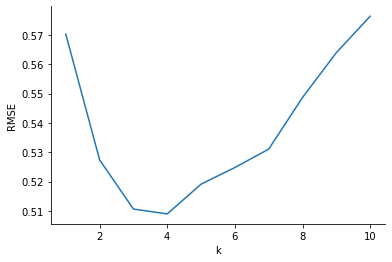

In [40]:
# Try values of k from 1 to 10, and find the mean squared error
# for each
mses = []
candidate_ks = range(1, 11)
import tqdm
for k in tqdm.tqdm(candidate_ks):
    mses.append(get_rmse(df_movies, k))
    
plt.plot(range(1,11), mses)
plt.xlabel('k')
plt.ylabel('RMSE')
sns.despine()

In [41]:
min(mses)

0.5089609632731398

In [42]:
best_k = candidate_ks[mses.index(min(mses))]

In [43]:
# (Note that in reality, we should split the data into a training and
# test set before finding the best k)

### A practical system

In [44]:
def movie_rec_system(person = 'Daniel Guetta', people_to_show=4):
    if person == '':
        return
    
    # Find the row for this person
    person_row = get_row_index(df_movies, person)

    # Get all the distances from this person; these will be returned
    # in order
    dists = all_dists(df_movies, person_row)
    
    # The first people_to_show need to appear in the output DataFrame,
    # as well as the user of interest
    output_users = [person_row] + [i[0] for i in dists[:people_to_show]]
    
    # Make predictions for every person using k-NN, and put
    # them in a DataFrame
    df_preds = {i:make_preds(df_movies, i, best_k) for i in output_users}
    df_preds = pd.DataFrame(df_preds).transpose().round(2)

    # Remove all movies that the user has already seen
    for movie in df_preds:
        for user in df_preds.index:
            if pd.notnull(df_movies.loc[user, movie]):
                df_preds.loc[user, movie] = ''
    
    # For each person in the list, get the movies they AND the person
    # of interest have no watched. Find the one with the highest
    # average rating, and recommend it as the one the two should
    # watch
    print('The following are the best movies to watch with the people closest to you:')
    for u in output_users[1:]:
        # Get a DataFrame with only the user of interest and this user
        df = df_preds.loc[[person_row, u], :]
        
        # Only keep columns in which there are no missing entries
        df = df[df.columns[(df == '').sum() == 0]]
        
        # Find the mean score, and sort by the result
        df = df.mean().sort_values(ascending=False)
        
        # Print
        print('  - Best movie to watch with ' + df_movies.loc[u, 'name'] + ' is ' + df.index[0])
            
    # Add names to the DataFrame
    df_preds.insert(0, 'Name', df_movies.loc[output_users, 'name'])
    
    # Print out the DataFrame
    print('These recommendations were based on the following data')
    
    return df_preds

In [45]:
from ipywidgets import interact, IntSlider, Combobox

In [46]:
interact(movie_rec_system,
            person=Combobox(placeholder='',
                            options=df_movies.name.tolist(),
                            description='Pick a person',
                            ensure_option=True,
                            disabled=False),
            people_to_show = IntSlider(description='# people to show', min=2, max=10))

interactive(children=(Combobox(value='', description='Pick a person', ensure_option=True, options=('Jiaping Zh…

<function __main__.movie_rec_system(person='Daniel Guetta', people_to_show=4)>

# Model-based collaborative filtering

In [47]:
# Number of latent factors
f = 2

### Basic version

In [48]:
# Create DataFrames to store the parameters

# Movie attributes
a = pd.DataFrame(0, index=range(f), columns=movies)

# User personas
p = pd.DataFrame(0, index=range(f), columns=df_movies.index)

# Go through the parameter DataFrames, and fill then with random values
import numpy as np
np.random.seed(123)
for df in [a, p]:
    for user in df.index:
        for movie in df:
            df.loc[user, movie] = np.random.uniform()

In [49]:
def make_pred(user, movie):
    '''
    This function will take a user ID and a movie, and make a prediction
    based on the current set of parameters.
    '''    
    return(a[movie]*p[user]).sum()

In [50]:
def get_rmse():
    '''
    Given the current parameters, this function calculates the RMSE of
    predictions
    '''
    
    total_error = 0
    n_errors = 0
    
    for user in df_movies.index:
        for movie in movies:
            if pd.notnull(df_movies.loc[user, movie]):
                total_error += (df_movies.loc[user, movie] - make_pred(user, movie))**2
                n_errors += 1
    
    return (total_error/n_errors)

In [51]:
def sgd_step():
    '''
    This function takes a single step in the stochastic gradient descent
    algorithm, going through every rating once to update the parameters
    '''
    
    for user in df_movies.index:
        for movie in movies:
            if pd.notnull(df_movies.loc[user, movie]):
                # Calculate the error for this rating
                error = df_movies.loc[user, movie] - make_pred(user, movie)
                
                # Take a step in the direction of the gradient
                a[movie] += gamma*error*p[user]
                p[user] += gamma*error*a[movie]

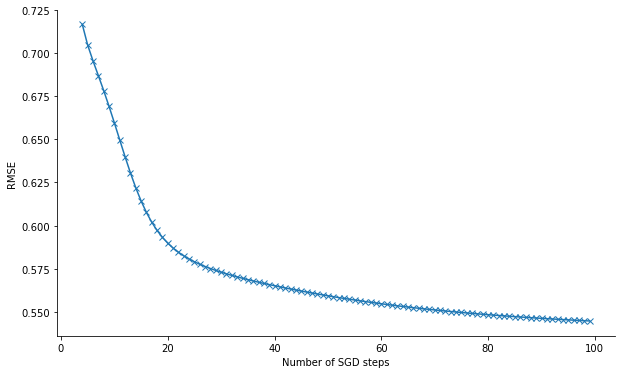

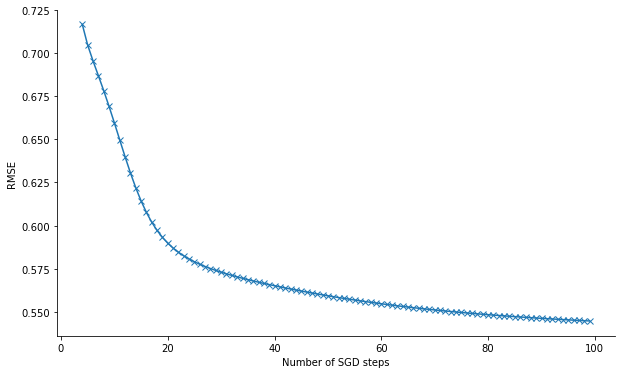

In [52]:
# Perform stochastic gradient descent

# Learning rate/step size
gamma = 0.02

# Number of steps
n_steps = 100

# Prepare to plot dynamically
from IPython import display

rmses = [get_rmse()]
for i in range(n_steps):
    # Clear the plot and the display
    plt.close()
    display.clear_output(wait=True)
    
    # Plot the 4th step onward (so as not to distort the axis with
    # the first two steps which will be terrible)
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(range(4, len(rmses)), rmses[4:], marker='x')
    axes.set_xlabel('Number of SGD steps')
    axes.set_ylabel('RMSE')
    sns.despine()
    display.display(plt.gcf())
    
    # Carry out a stochastic gradient descent step, and calculate
    # the RMSE
    sgd_step()
    rmses.append(get_rmse())

In [53]:
print(rmses[-1])

0.5444531134534666


### Including fixed effects

In [54]:
# Create DataFrames to store the parameters

import numpy as np
np.random.seed(123)

# Movie attributes and fixed effects
a = pd.DataFrame(0, index=range(f), columns=movies)
alpha = {i:np.random.uniform() for i in movies}

# User personas and fixed effects
p = pd.DataFrame(0, index=range(f), columns=df_movies.index)
pi = {i:np.random.uniform() for i in df_movies.index}

# Mean rating
mu = [np.random.uniform()]

# Gender effect
phi = [np.random.uniform()]

# Go through the parameter DataFrames, and fill then with random values
for df in [a, p]:
    for user in df.index:
        for movie in df:
            df.loc[user, movie] = np.random.uniform()

In [55]:
def make_pred(user, movie):
    '''
    This function will take a user ID and a movie, and make a prediction
    based on the current set of parameters.
    '''
    
    pred = (a[movie]*p[user]).sum() + mu[0] + alpha[movie] + pi[user]
    
    # If the user is a woman, add that fixed effect
    if df_movies.loc[user, 'gender'] == 'F':
        pred += phi[0]
    
    return pred

In [56]:
# The get_rmse function doesn't change, it'll just use the updated
# make_prediction

In [57]:
def sgd_step():
    '''
    This function takes a single step in the stochastic gradient descent
    algorithm, going through every rating once to update the parameters
    '''
    
    for user in df_movies.index:
        for movie in movies:
            if pd.notnull(df_movies.loc[user, movie]):
                # Calculate the error for this rating
                error = df_movies.loc[user, movie] - make_pred(user, movie)
                
                # Take a step in the direction of the gradient
                a[movie]     += gamma*error*p[user]
                p[user]      += gamma*error*a[movie]
                mu[0]        += gamma*error
                alpha[movie] += gamma*error
                pi[user]     += gamma*error
                
                if df_movies.loc[user, 'gender'] == 'F':
                    phi[0] += gamma*error

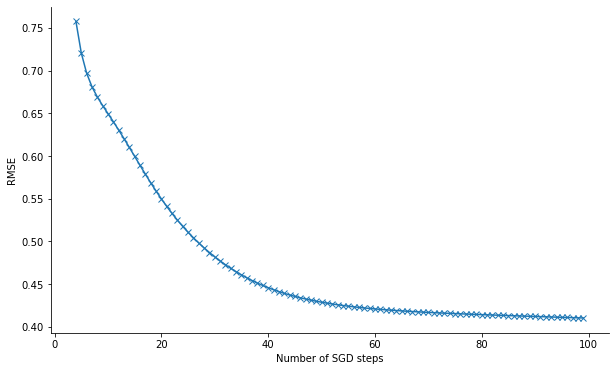

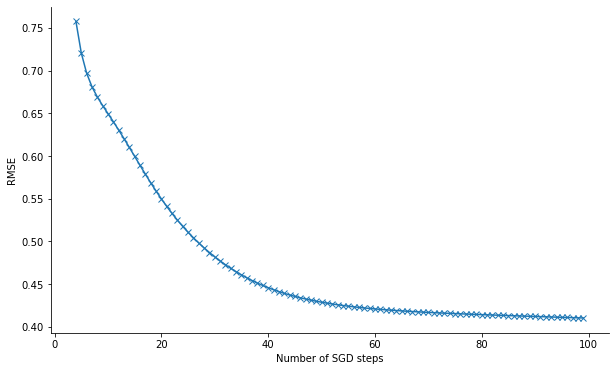

In [58]:
# Perform stochastic gradient descent

# Learning rate/step size
gamma = 0.02

# Number of steps
n_steps = 100

# Prepare to plot dynamically
from IPython import display

rmses = [get_rmse()]
for i in range(n_steps):
    # Clear the plot and the display
    plt.close()
    display.clear_output(wait=True)
    
    # Plot the 4th step onward (so as not to distord the axis with
    # the first two steps which will be terrible)
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(range(4, len(rmses)), rmses[4:], marker='x')
    axes.set_xlabel('Number of SGD steps')
    axes.set_ylabel('RMSE')
    sns.despine()
    display.display(plt.gcf())
    
    # Carry out a stochastic gradient descent step, and calculate
    # the RMSE
    sgd_step()
    rmses.append(get_rmse())

In [59]:
print(rmses[-1])

0.4102191131249827


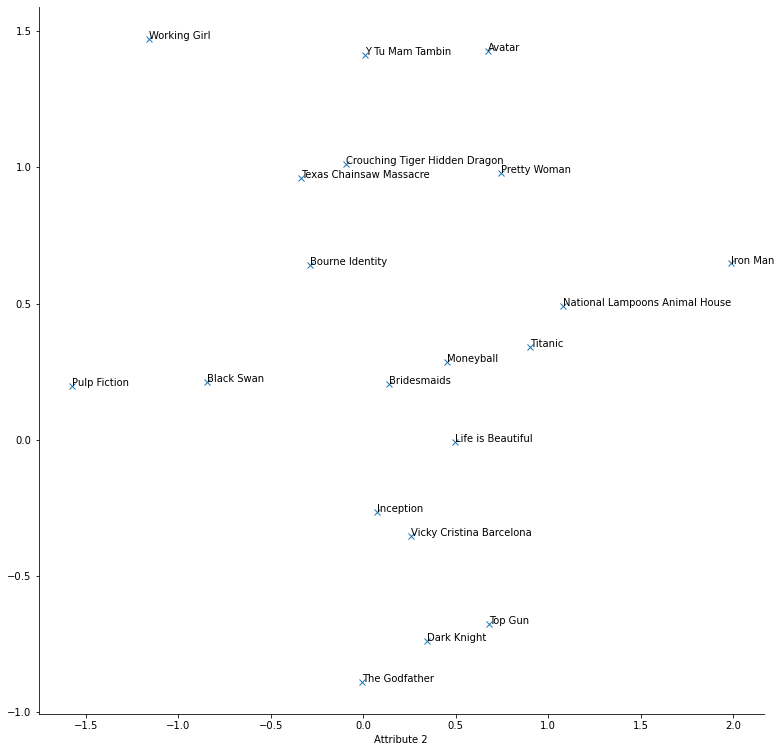

In [60]:
# Plot the movie attributes
fig, axes = plt.subplots(1, 1, figsize=(13, 13))

axes.plot(a.loc[0,:], a.loc[1,:], marker='x', linewidth=0)

axes.set_xlabel('Attribute 1')
axes.set_xlabel('Attribute 2')

for c in a:
    axes.text(a.loc[0, c], a.loc[1, c], c)

sns.despine()

In [61]:
# View the movie fixed effect
pd.Series(alpha).sort_values()

Iron Man                         -0.577136
Texas Chainsaw Massacre          -0.567978
Pretty Woman                     -0.152775
National Lampoons Animal House   -0.119873
Working Girl                      0.044659
Avatar                            0.073423
Bridesmaids                       0.309215
Titanic                           0.499575
Vicky Cristina Barcelona          0.540915
Y Tu Mam Tambin                   0.566716
Crouching Tiger Hidden Dragon     0.578363
Bourne Identity                   0.726599
Moneyball                         0.744853
Top Gun                           0.793195
Black Swan                        1.064641
Life is Beautiful                 1.186204
Dark Knight                       1.268231
Inception                         1.488327
The Godfather                     1.576694
Pulp Fiction                      1.671313
dtype: float64

In [62]:
# View the gender fixed effect
phi

[0.9275842401521475]